In [4]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [5]:
# Robust project root detection
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "output" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

PREV_PATH = RAW_DIR / "1- mental-illnesses-prevalence.csv"
BURDEN_PATH = RAW_DIR / "2- burden-disease-from-each-mental-illness(1).csv"

if not PREV_PATH.exists():
    raise FileNotFoundError(f"Missing file: {PREV_PATH}")
if not BURDEN_PATH.exists():
    raise FileNotFoundError(f"Missing file: {BURDEN_PATH}")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("FIG_DIR:", FIG_DIR)


PROJECT_ROOT: /Users/sergio/Library/Mobile Documents/com~apple~CloudDocs/Master/First Semester/Visual Data Science/VDS_Mental_Health
RAW_DIR: /Users/sergio/Library/Mobile Documents/com~apple~CloudDocs/Master/First Semester/Visual Data Science/VDS_Mental_Health/data/raw
FIG_DIR: /Users/sergio/Library/Mobile Documents/com~apple~CloudDocs/Master/First Semester/Visual Data Science/VDS_Mental_Health/output/figures


In [7]:
prev = pd.read_csv(PREV_PATH)
burden = pd.read_csv(BURDEN_PATH)

# Keep only countries (ISO-3 codes); removes aggregates
prev = prev[prev["Code"].notna() & (prev["Code"].str.len() == 3)].copy()
burden = burden[burden["Code"].notna() & (burden["Code"].str.len() == 3)].copy()

prev_features = [c for c in prev.columns if c not in ["Entity", "Code", "Year"]]
burden_features = [c for c in burden.columns if c not in ["Entity", "Code", "Year"]]

print("Prev features:", len(prev_features))
print("Burden features:", len(burden_features))
print("Prev shape:", prev.shape)
print("Burden shape:", burden.shape)


Prev features: 5
Burden features: 5
Prev shape: (6120, 8)
Burden shape: (6120, 8)


In [8]:
def compute_slopes(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    For each (Entity, Code), fit y = a*Year + b for each feature and return slope a.
    Sorting by Year ensures stable behavior even if input is unordered.
    """
    rows = []
    for (entity, code), g in df.groupby(["Entity", "Code"], sort=False):
        g = g.sort_values("Year")
        years = g["Year"].to_numpy()

        row = {"Entity": entity, "Code": code}
        for feat in features:
            y = g[feat].to_numpy()
            mask = ~np.isnan(y)
            if mask.sum() < 2:
                row[f"{feat}_slope"] = np.nan
            else:
                row[f"{feat}_slope"] = np.polyfit(years[mask], y[mask], 1)[0]
        rows.append(row)

    out = pd.DataFrame(rows)
    return out.dropna()

prev_slopes = compute_slopes(prev, prev_features)
burden_slopes = compute_slopes(burden, burden_features)

model_df = prev_slopes.merge(burden_slopes, on=["Entity", "Code"], how="inner")
feature_cols = [c for c in model_df.columns if c not in ["Entity", "Code"]]

print("Model table shape:", model_df.shape)
model_df.head()


Model table shape: (204, 12)


,Entity,Code,Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized_slope,Depressive disorders (share of population) - Sex: Both - Age: Age-standardized_slope,Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized_slope,Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized_slope,Eating disorders (share of population) - Sex: Both - Age: Age-standardized_slope,DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders_slope,DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia_slope,DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder_slope,DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders_slope,DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Anxiety disorders_slope
0,Afghanistan,AFG,-0.000111,-0.002252,0.005200,-5.528656e-05,0.000064,-0.219620,-0.028034,0.051290,0.027305,0.653935
1,Albania,ALB,0.000282,0.002307,0.006054,2.516188e-05,0.001459,0.521217,0.214798,0.021992,0.307548,0.634420
2,Algeria,DZA,-0.000021,-0.006355,0.004299,5.902514e-07,0.000884,-1.364565,-0.016253,-0.004668,0.189496,0.419685
3,American Samoa,ASM,-0.000273,-0.001516,0.003879,9.357399e-06,-0.000314,-0.437090,-0.208343,-0.005706,-0.067051,0.322643
4,Andorra,AND,-0.000072,-0.003486,0.003644,3.880709e-04,0.002082,-0.791922,-0.064684,0.069537,0.445851,0.310551


In [9]:
X = model_df[feature_cols].to_numpy()

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print("Feature matrix shape:", Xz.shape)


Feature matrix shape: (204, 10)


Silhouette scores:
 2    0.241094
3    0.254559
4    0.266102
5    0.255213
6    0.258826
7    0.230575
8    0.208038
Name: silhouette_score, dtype: float64

Best k by silhouette: 4


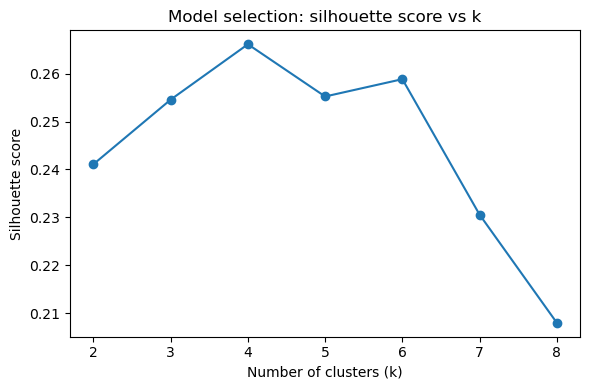

In [10]:
ks = list(range(2, 9))
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xz)
    try:
        score = silhouette_score(Xz, labels)
    except Exception:
        score = np.nan
    sil_scores.append(score)

sil_series = pd.Series(sil_scores, index=ks, name="silhouette_score")
best_k = int(sil_series.idxmax())

print("Silhouette scores:\n", sil_series)
print("\nBest k by silhouette:", best_k)

plt.figure(figsize=(6, 4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Model selection: silhouette score vs k")
plt.tight_layout()
plt.savefig(FIG_DIR / "model_silhouette.png", dpi=300)
plt.show()


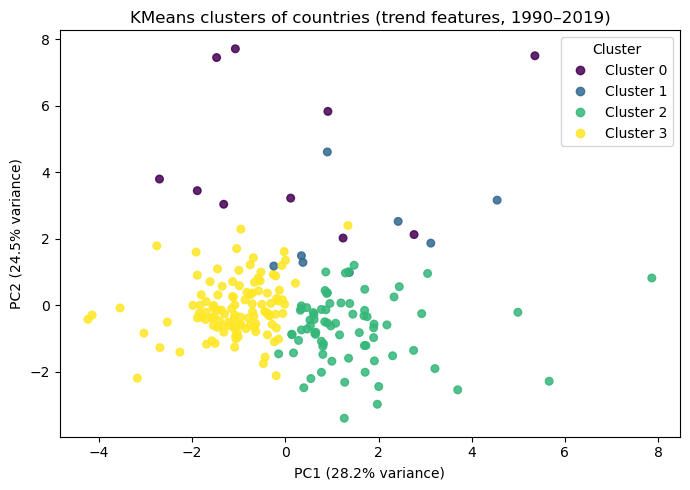

In [11]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Xz)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xz)
var = pca.explained_variance_ratio_

plt.figure(figsize=(7, 5))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=clusters, s=30, alpha=0.85)
plt.xlabel(f"PC1 ({var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({var[1]*100:.1f}% variance)")
plt.title("KMeans clusters of countries (trend features, 1990–2019)")

handles, _ = sc.legend_elements(prop="colors", alpha=0.85)
plt.legend(
    handles,
    [f"Cluster {i}" for i in range(best_k)],
    title="Cluster",
    loc="best"
)

plt.tight_layout()
plt.savefig(FIG_DIR / "model_pca_clusters.png", dpi=300)
plt.show()


In [12]:
tmp = model_df.copy()
tmp["cluster"] = clusters

cluster_sizes = tmp["cluster"].value_counts().sort_index()
print("Cluster sizes:\n", cluster_sizes)

cluster_means = tmp.groupby("cluster")[feature_cols].mean(numeric_only=True)
print("\nCluster mean slopes (first 10 columns):\n", cluster_means.iloc[:, :10])

global_mean = tmp[feature_cols].mean(numeric_only=True)
diff = (cluster_means - global_mean).abs()
top_sep = diff.mean(axis=0).sort_values(ascending=False).head(8)
print("\nTop separating slope-features:\n", top_sep)

out_path = PROCESSED_DIR / "model_country_clusters.csv"
tmp[["Entity", "Code", "cluster"]].to_csv(out_path, index=False)
print("\nSaved cluster assignments to:", out_path)


Cluster sizes:
 cluster
0     10
1      8
2     74
3    112
Name: count, dtype: int64

Cluster mean slopes (first 10 columns):
          Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized_slope  \
cluster                                                                                            
0                                                 0.000062                                         
1                                                 0.000035                                         
2                                                 0.000307                                         
3                                                 0.000003                                         

         Depressive disorders (share of population) - Sex: Both - Age: Age-standardized_slope  \
cluster                                                                                         
0                                                 0.005514                   